<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/8_NLP_Basics/NLP3_Transformers_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 The Illustrated Transformer



### The Transformer Concept: A High-Level Overview

- Before Transformers, recurrent neural networks (RNNs) like LSTMs and GRUs were state-of-the-art for sequence processing. However, they had a major limitation: they process text sequentially (word by word). This makes it difficult to capture long-range dependencies in text and makes parallelization impossible.

- The 2017 paper **"Attention Is All You Need"** introduced the Transformer, which revolutionized NLP by getting rid of recurrence entirely. Its core idea is **self-attention**.

> **Analogy**: Imagine a group of people discussing a sentence. Instead of listening one by one, everyone can look at all the other words simultaneously. Self-attention allows each word in a sentence to look at all other words in the *same sentence* to better understand its own meaning in context.

For example, in the sentence "The `animal` didn't cross the street because `it` was too tired," the self-attention mechanism can learn that the word `it` strongly refers to `animal`. It does this without needing to process the words in between sequentially.

The Transformer architecture consists of two main parts:
- **The Encoder**: Reads and understands the input sequence (e.g., an English sentence).
- **The Decoder**: Generates the output sequence (e.g., the French translation), paying attention to the encoder's output.

## **Classical Encoder-Decoder (image example)**

![encdec](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*MR6_IaOCoxbXRPuFbIJlUg.jpeg?raw=1)

## **Transformer (Encoder-Decoder evolution)**

![transformer](https://i.postimg.cc/Bn7QmpQS/1-43lg-CTy-M5c-TTABj-C2-VEHd-A.png?raw=1)

**Nx**: same structure repeated Nx times.

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set a seed for reproducibility
tf.random.set_seed(42)

### Implementing Multi-Head Attention

Instead of performing attention just once, Multi-Head Attention (MHA) does it multiple times in parallel and combines the results. This allows the model to learn different types of relationships from different "perspectives" or "subspaces."

The process for each head is:
1.  **Project**: The input vectors (for Query, Key, and Value) are linearly projected into a smaller dimension.
2.  **Scale-Dot Product Attention**: The core attention formula is applied: $$\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^\top} { \sqrt(d_k) }\right)  V$$
3.  **Concatenate & Project**: The outputs from all heads are concatenated and projected back to the original dimension.



In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        # Linear layers for Query, Key, Value
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        # Final linear layer
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True) # (..., seq_len_q, seq_len_k)

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            # Add a very small number (-1e9) to the masked positions
            # so they become close to zero after softmax.
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v) # (..., seq_len_q, depth_v)

        return output, attention_weights

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # Pass inputs through linear layers
        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k) # (batch_size, seq_len, d_model)
        v = self.wv(v) # (batch_size, seq_len, d_model)

        # Split into multiple heads
        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len_v, depth)

        # Apply scaled dot-product attention
        scaled_attention, attention_weights = self.scaled_dot_product_attention(
            q, k, v, mask)

        # Concatenate heads
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # Pass through final linear layer
        output = self.dense(concat_attention)
        return output, attention_weights

### Visualizing the Attention Mask

- Now let's use our `MultiHeadAttention` layer and visualize what it's doing. We will feed it a simple sentence and plot the attention weights. The plot will show which words are paying attention to which other words.

- In **self-attention** (which we use in an encoder), Query, Key, and Value are all derived from the *same* input sequence.

Input shape: (1, 9, 128)
Output shape: (1, 9, 128)
Attention weights shape: (1, 8, 9, 9)


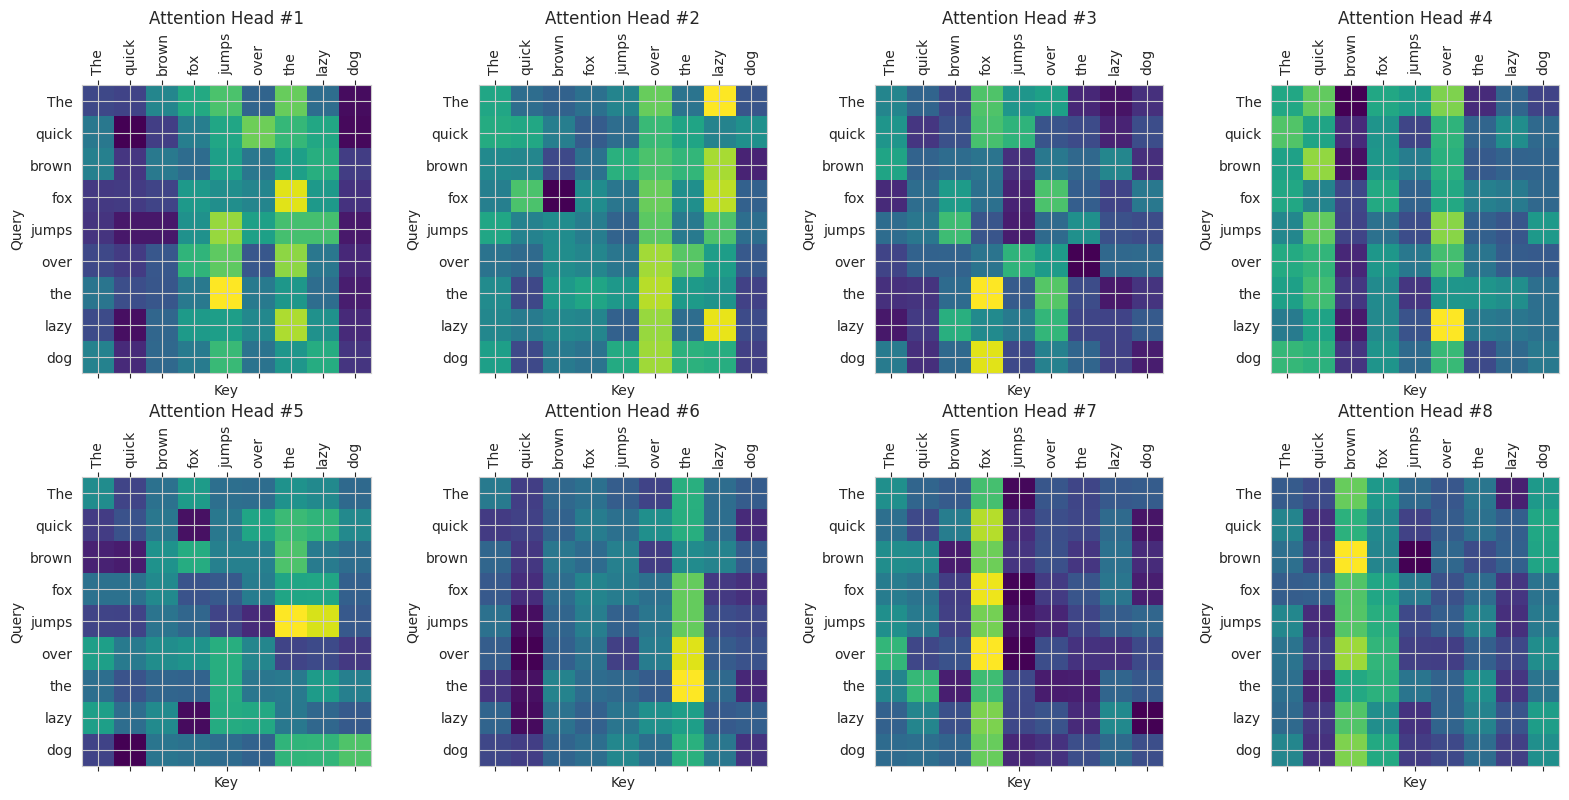

In [25]:
def plot_attention_head(attention, input_sentence, head_index=0):
    ax = plt.gca()
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 10}

    ax.set_xticks(range(len(input_sentence)))
    ax.set_yticks(range(len(input_sentence)))

    ax.set_xticklabels(input_sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels(input_sentence, fontdict=fontdict)

    ax.set_xlabel('Key', fontdict=fontdict)
    ax.set_ylabel('Query', fontdict=fontdict)
    ax.set_title(f'Attention Head #{head_index+1}')


# --- Setup for Visualization ---
sentence = "The quick brown fox jumps over the lazy dog".split()
sequence_len = len(sentence)
d_model = 128  # Embedding dimension
num_heads = 8

# Create a dummy input (batch_size=1, sequence_len, d_model)
# In a real model, this would come from an embedding layer.
dummy_input = tf.random.uniform((1, sequence_len, d_model))

# Instantiate our MHA layer
mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

# Get the output and attention weights. For self-attention, v=k=q=dummy_input
# The mask is None because we want every word to see every other word.
output, attention_weights = mha(v=dummy_input, k=dummy_input, q=dummy_input, mask=None)

# attention_weights shape: (batch_size, num_heads, seq_len, seq_len)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

# --- Plotting ---
plt.figure(figsize=(16, 8))
for i in range(num_heads):
    plt.subplot(2, 4, i + 1)
    # Extract attention for the first (and only) batch item, and for head i
    head_attention = attention_weights[0, i]
    plot_attention_head(head_attention, sentence, head_index=i)

plt.tight_layout()
plt.show()

#### Interpretation of the Visualization

Each of the 8 plots above represents one "attention head". The y-axis represents the **Query** word (the word that is "looking") and the x-axis represents the **Key** word (the word being "looked at").

A brighter square at `(row, col)` means that the word at `row` pays a high degree of attention to the word at `col` when computing its new representation. Since this is an untrained model, the attention patterns are random. After training, meaningful patterns emerge, such as pronouns attending to the nouns they refer to.

### The Encoder Block

An Encoder isn't just a Multi-Head Attention layer. It's a stack of identical layers, each with two sub-layers:

1.  **Multi-Head Self-Attention**: The MHA layer we just built.
2.  **Position-wise Feed-Forward Network (FFN)**: A simple fully-connected network applied independently to each position.

Crucially, each of these two sub-layers has a residual connection around it, followed by a layer normalization. This helps stabilize training in deep models.

`output = LayerNorm(x + Sublayer(x))`

In [26]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderBlock, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
            tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, mask):
        # Multi-Head Attention sub-layer
        attn_output, _ = self.mha(x, x, x, mask)  # Self-attention
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # Residual connection and layer norm

        # Feed-Forward Network sub-layer
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # Residual connection and layer norm

        return out2

# Let's test the encoder block
d_model = 64
num_heads = 4
dff = 128 # Feed-forward network dimension

encoder_block = EncoderBlock(d_model, num_heads, dff)
dummy_input = tf.random.uniform((1, 50, d_model)) # (batch_size, seq_len, d_model)
encoder_output = encoder_block(dummy_input, mask=None)

print(f"Input shape: {dummy_input.shape}")
print(f"Encoder Block output shape: {encoder_output.shape}")

Input shape: (1, 50, 64)
Encoder Block output shape: (1, 50, 64)


## Cross-Attention and the Decoder

### Cross-Attention Explained

- While the **Encoder** uses **self-attention** to understand the input sequence, the **Decoder** needs a way to pay attention to the encoder's output. This is where **cross-attention** comes in.

- The mechanism is identical to self-attention, but the inputs for Query, Key, and Value are different:
- **Query (Q)**: Comes from the decoder's own sequence (the partially generated translation).
- **Key (K) and Value (V)**: Both come from the final output of the **Encoder**.

> **Analogy**: Imagine a human translator translating an English sentence to French. To decide the next French word, they look at the French words they have already written (this is the Decoder's self-attention). Then, they look back at the *entire English source sentence* to see which English words are most relevant for the next French word. This act of looking at the source sentence is **cross-attention**.

- This allows the decoder at each step to focus on the most relevant parts of the *input sentence* to generate the next output token.

**Use Cases for Cross-Attention:**
- **Machine Translation**: The decoder attends to the source sentence.
- **Text Summarization**: The decoder attends to the full article to generate the summary.
- **Image Captioning**: A text-generating decoder attends to the features of an image (processed by a vision encoder like a CNN) to generate a caption.

# Practical implementation


We will see the transformers potential regarding the current two main AI perspectives:

- **Predictive AI**: Text Classification - We'll classify IMDB movie reviews as positive or negative.




In [27]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

# Set plotting style
sns.set_style("whitegrid")

# Predictive AI - Text Classification

- Here, we'll build a Transformer-based classifier to determine the sentiment of movie reviews.

## Load and Preprocess the IMDB Dataset

We'll use the classic [IMDB movie review dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb). Keras provides a convenient way to load it, already pre-tokenized.

In [28]:
# Cell 2: Load and Prepare Data
vocab_size = 20000  # Only consider the top 20,000 words
maxlen = 200  # Max length of reviews (in words)

(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(f"{len(x_train)} training sequences")
print(f"{len(x_val)} validation sequences")

# Pad sequences to the same length
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")

25000 training sequences
25000 validation sequences
x_train shape: (25000, 200)
x_val shape: (25000, 200)


## Building the Transformer Block

- The core of the Transformer is the "Transformer Block," which consists of Multi-Head Self-Attention and a Feed-Forward Network. We'll implement this as a custom Keras layer.

In [29]:
# Cell 3: Transformer Block Layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        # Multi-head self-attention
        attn_output, attention_weights = self.att(inputs, inputs, return_attention_scores=True) # Get attention weights here
        # Dropout and residual connection
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward network
        ffn_output = self.ffn(out1)
        # Dropout and residual connection
        ffn_output = self.dropout2(ffn_output)
        # The output of the block has the same shape as the input
        # We also return the attention weights for visualization
        return self.layernorm2(out1 + ffn_output), attention_weights # Return attention weights

## Building the Full Classification Model

Now we combine token embeddings, positional encodings, and our TransformerBlock to create the full classifier.


In [30]:
# Cell 4: Token and Positional Embedding Layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x, training=None): # Added training argument
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Cell 5: Create and Compile the Classifier Model
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x, _ = transformer_block(x) # Added training argument
x = layers.GlobalAveragePooling1D()(x) # Pool the outputs of all words
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Binary classification

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_2  │ (None, 200, 32)        │       646,400 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ [(None, 200, 32),      │        10,656 │
│ (TransformerBlock)              │ (None, 2, 200, 200)]   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657,737 (2.51 MB)

 Trainable params: 657,737 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

Let's train our sentiment classifier. This may take a few minutes.

In [31]:
# Cell 6: Train the Classifier
history = model.fit(
    x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val)
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7111 - loss: 0.5209 - val_accuracy: 0.8788 - val_loss: 0.2845
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9150 - loss: 0.2195 - val_accuracy: 0.8728 - val_loss: 0.3161
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9487 - loss: 0.1402 - val_accuracy: 0.8553 - val_loss: 0.4353
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9694 - loss: 0.0911 - val_accuracy: 0.8499 - val_loss: 0.5473
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9748 - loss: 0.0765 - val_accuracy: 0.8370 - val_loss: 0.6355


# Evaluate the Model

Let's see how well our model performs on the validation set.

In [32]:
# Cell 7: Evaluate the Classifier
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

# Generate a classification report
y_pred_probs = model.predict(x_val)
y_pred = (y_pred_probs > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Negative', 'Positive']))

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8404 - loss: 0.6236
Validation Accuracy: 83.70%
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.90      0.85     12500
    Positive       0.89      0.77      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



## Visualization: Self-Attention Scores

- To understand what the model is "looking at," we can visualize the self-attention scores. A high score between two words means the model strongly associates them when creating a representation for the first word.

Visualizing attention for review:


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_75']
Received: inputs=Tensor(shape=(1, 200))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


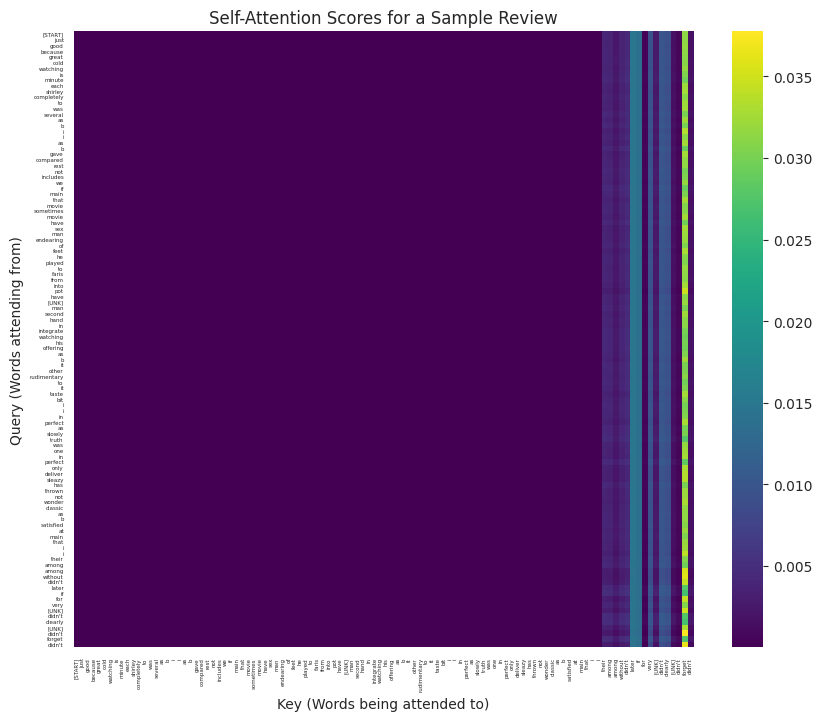

In [33]:
# Cell 8: Function to Visualize Self-Attention
def visualize_attention(model, sentence_indices, word_to_index):
    # Create a model to output attention scores
    attention_model = keras.Model(
        inputs=model.inputs,
        outputs=model.layers[2].call(model.layers[1](model.inputs[0]))[1] # transformer_block output, add training=False
    )

    # Reverse the word index to get words
    index_to_word = {v: k for k, v in word_to_index.items()}
    # The first few indices are reserved, so we shift them
    index_to_word[0] = "[PAD]"
    index_to_word[1] = "[START]"
    index_to_word[2] = "[UNK]"

    # Get words from indices
    words = [index_to_word.get(i, "?") for i in sentence_indices if i != 0] # Exclude padding
    padded_sentence = keras.preprocessing.sequence.pad_sequences([sentence_indices], maxlen=maxlen)

    # Get attention scores
    attention_scores = attention_model.predict(padded_sentence)

    # Plotting
    # We will visualize the attention scores from the first head
    attention_head = attention_scores[0, 0, :, :]

    # We only care about the attention between actual words, not padding
    attention_head_unpadded = attention_head[:len(words), :len(words)]

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_head_unpadded, xticklabels=words, yticklabels=words, cmap="viridis")
    plt.title("Self-Attention Scores for a Sample Review")
    plt.xlabel("Key (Words being attended to)")
    plt.ylabel("Query (Words attending from)")
    plt.xticks(rotation=90,fontsize=4)
    plt.yticks(fontsize=4)
    plt.show()

# Cell 9: Run the Visualization
# Get the original word index from Keras
word_to_index = keras.datasets.imdb.get_word_index()
# Take a sample sentence from the validation set
sample_idx = 4 # Try different indices
sample_sentence_indices = x_val[sample_idx]

print("Visualizing attention for review:")
visualize_attention(model, sample_sentence_indices, word_to_index)


## Visualization: The Causal Mask

- For text generation, the model should only be able to see past tokens, not future ones.

- This is enforced by a causal mask (or look-ahead mask). Let's visualize what this mask looks like.

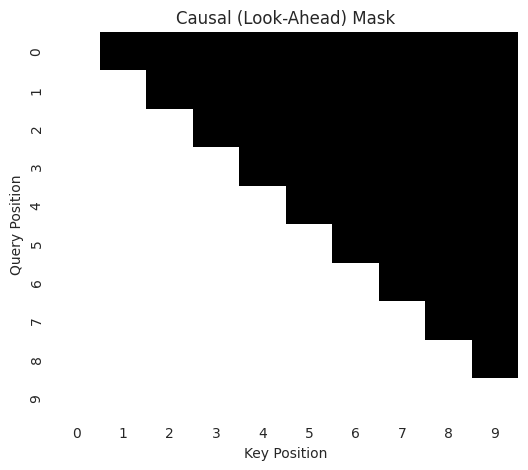

In [34]:
# Cell 11: Visualize Causal Mask
def create_causal_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

mask = create_causal_mask(10)

plt.figure(figsize=(6, 5))
sns.heatmap(mask, cmap="Greys", cbar=False)
plt.title("Causal (Look-Ahead) Mask")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()

# Conceptual Understanding - Cross-Attention

- We haven't explicitly implemented cross-attention because it's used in Encoder-Decoder architectures (like in the original Transformer paper for machine translation), not in the two models we built.

## What is Cross-Attention?

- **Self-Attention**: A sequence attends to itself. (e.g., The English sentence "The cat sat" attends to itself).
- **Cross-Attention**: A sequence attends to another sequence. This is the bridge between the encoder and the decoder.

## How it Works (e.g., in Translation):

**Encoder**: The encoder processes the source sentence (e.g., "The cat sat") using self-attention and produces a rich set of representations (let's call them encoder_outputs).

**Decoder**: The decoder's job is to generate the target sentence (e.g., "Le chat s'est assis") word by word.

**The Cross-Attention Layer**: This layer is inside the decoder. For each word the decoder generates, the cross-attention layer does the following:

-Query (Q): Comes from the decoder's own sequence (the partially generated French sentence).
-Key (K) and Value (V): Both come from the encoder_outputs (the representations of the English sentence).
-This allows the decoder, at each step of generating a French word, to "look back" at the entire English source sentence and decide which English words are most relevant for predicting the next French word.
-Visualization of Cross-Attention (Conceptual)

If we were to plot the cross-attention scores for a translation task, it might look like this:

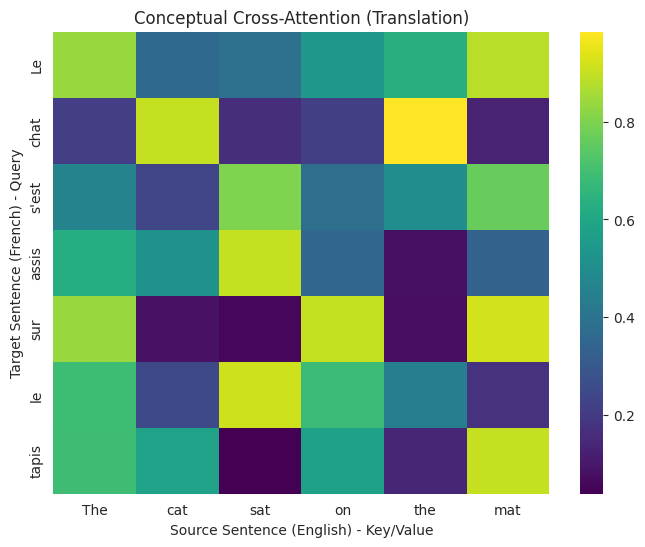

In [35]:
# Cell 19: Conceptual Cross-Attention Plot
# This is a mock plot to illustrate the concept.
source_sentence = ["The", "cat", "sat", "on", "the", "mat"]
target_sentence = ["Le", "chat", "s'est", "assis", "sur", "le", "tapis"]

# Mock attention scores (in a real model, these would be learned)
mock_attention = np.random.rand(len(target_sentence), len(source_sentence))
mock_attention[1, 1] = 0.9 # 'chat' attends to 'cat'
mock_attention[2, 2] = 0.8 # 's'est' attends to 'sat'
mock_attention[3, 2] = 0.9 # 'assis' attends to 'sat'
mock_attention[4, 3] = 0.9 # 'sur' attends to 'on'
mock_attention[6, 5] = 0.9 # 'tapis' attends to 'mat'


plt.figure(figsize=(8, 6))
sns.heatmap(mock_attention, xticklabels=source_sentence, yticklabels=target_sentence, cmap="viridis")
plt.title("Conceptual Cross-Attention (Translation)")
plt.xlabel("Source Sentence (English) - Key/Value")
plt.ylabel("Target Sentence (French) - Query")
plt.show()

**Interpretation**:

-This plot shows that when the decoder is about to generate the word "chat", its cross-attention mechanism focuses heavily on the word "cat" from the source sentence.

-Similarly, when generating "assis" (sat), it attends to the source word "sat". This is the fundamental mechanism that allows encoder-decoder models to perform tasks like translation and summarization.